In [1338]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.interpolate import splprep, splev
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import AffinityPropagation, KMeans, MeanShift, estimate_bandwidth, Birch
from sklearn.metrics import pairwise_distances
from skimage import io
from PIL import Image
import statistics
import time
import math
import glob

In [1291]:
def plotimage(img, title, sub1, sub2, sub3):
    plt.subplot(sub1, sub2, sub3)
    plt.title(title)
    if(len(img.shape) < 3):
        plt.imshow(img, cmap='gray')
    else :
        plt.imshow(img)

In [1292]:
def plot_hist(data):
    plt.figure(figsize=(15,6))
    values, bins, bars =plt.hist(data, density=False,bins=np.arange(0, 650, 1))
    plt.xlabel('axis')
    plt.ylabel("Counts")
    plt.xticks(np.arange(0, 600, 50))
    plt.show()

In [1295]:
def filePathsGen(rootPath, pre_paths=[]):
    if pre_paths != []:
        paths = pre_paths
    else:
        paths=[]
    for dirPath,dirNames,fileNames in os.walk(rootPath):
        for fileName in fileNames:
            fullPath=os.path.join(dirPath,fileName)
            if (fileName.split('.')[-1] == 'jpg') | (fileName.split('.')[-1] == 'JPG'):
                base=fileName.split('-')
                die=base[-2]
                wafer=base[-3]
                lot=base[-4]
                recipe=base[-5]
                classes= dirPath.split(os.sep)[-2] if (dirPath.split(os.sep)[-2]=='OK')|(dirPath.split(os.sep)[-2]=='NG') else dirPath.split(os.sep)[-1]
                defect= dirPath.split(os.sep)[-1] if (dirPath.split(os.sep)[-2]=='OK')|(dirPath.split(os.sep)[-2]=='NG') else ''
                date=dirPath.split(os.sep)[-3] if (dirPath.split(os.sep)[-2]=='OK')|(dirPath.split(os.sep)[-2]=='NG') else dirPath.split(os.sep)[-2]
                
                paths.append((fullPath, fileName,date,classes,defect, recipe,lot,wafer,die ))
                
        df=pd.DataFrame(paths,columns=['fullPath','fileName','date','class','defect','recipe','lot','wafer','die'])
    return df

In [1296]:
paths=["/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/",
        "/tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/",
        "/tf/cp1ai01/COG/03_POC訓練資料/DM/20220729/",
]

dfPath_data=pd.DataFrame(columns=['fullPath','fileName','date','class','defect','recipe','lot','wafer','die'])
for path in paths:
    paths_data=filePathsGen(path)
    test_split=path.split('/')
    name=test_split[-1] if test_split[-1] else test_split[-2]
    paths_data['dir']=name
    print('Data path=\t\t\t',path)
    print('Shape(total)=\t\t\t',paths_data.shape)
    dfPath_data = pd.concat([dfPath_data,paths_data])

dfPath_data['defect_class']=dfPath_data['defect']+dfPath_data["class"]
dfPath_data.reset_index(inplace=True, drop=True)

Data path=			 /tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/
Shape(total)=			 (13000, 10)
Data path=			 /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/
Shape(total)=			 (25452, 10)
Data path=			 /tf/cp1ai01/COG/03_POC訓練資料/DM/20220729/
Shape(total)=			 (28699, 10)


In [1297]:
dfPath_line=dfPath_data[dfPath_data['defect']=='切割道']
dfPath_group=dfPath_line.set_index(["defect_class"]).groupby(level=["defect_class"]).size().to_frame('counts')
print(dfPath_group)

              counts
defect_class        
切割道NG             78
切割道OK          16706


In [1298]:
test=pd.concat([dfPath_line[dfPath_line['class']=="NG"].sample(n=70,random_state=5),
                dfPath_line[dfPath_line['class']=="OK"].sample(n=1000,random_state=5),
               ])
test

fullPath  \
13049  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/NG/切割道/...   
13034  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/NG/切割道/...   
12977  /tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/NG/切割道/...   
13068  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/NG/切割道/...   
67148  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220729/NG/切割道/...   
...                                                  ...   
26134  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/OK/切割道/...   
44037  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220729/OK/切割道/...   
32109  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/OK/切割道/...   
40924  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220729/OK/切割道/...   
28033  /tf/cp1ai01/COG/03_POC訓練資料/DM/20220115/OK/切割道/...   

                                        fileName      date class defect  \
13049  A-DMZGB1-P53DMC3-003-(+0160+0000)-001.JPG  20220115    NG    切割道   
13034  A-DMOXB3-P53DMGT-012-(+0077+0006)-069.JPG  20220115    NG    切割道   
12977     DMB9-R01DMF4-005-(+0126+0002)-1389.JPG  test_set    NG    切割道   
13068    DMO2O1-R02DMBT-034-(+0167+0004)-090.JPG  20220115    NG    切割道   
67148    DMW1A5-R26DMGT-010-(+0140+0002)-045.JPG  20220729    NG    切割道   
...                                          ...       ...   ...    ...   
26134  A-DMU1H2-P53DMC6-002-(+0134+0004)-941.JPG  20220115    OK    切割道   
44037    DMZCB3-R26DMEN-035-(+0129+0006)-085.JPG  20220729    OK    切割道   
32109    DMFDH1-P53DMTA-006-(+0232+0002)-013.JPG  20220115    OK    切割道   
40924    DMZCB3-R26DMHY-029-(+0133+0004)-108.JPG  20220729    OK    切割道   
28033    DMBDA1-RA2DMB9-004-(+0251+0001)-082.JPG  20220115    OK    切割道   

       recipe      lot wafer           die       dir defect_class  
13049  DMZGB1  P53DMC3   003  (+0160+0000)  20220115        切割道NG  
13034  DMOXB3  P53DMGT   012  (+0077+0006)  20220115        切割道NG  
12977    DMB9  R01DMF4   005  (+0126+0002)  test_set        切割道NG  
13068  DMO2O1  R02DMBT   034  (+0167+0004)  20220115        切割道NG  
67148  DMW1A5  R26DMGT   010  (+0140+0002)  20220729        切割道NG  
...       ...      ...   ...           ...       ...          ...  
26134  DMU1H2  P53DMC6   002  (+0134+0004)  20220115        切割道OK  
44037  DMZCB3  R26DMEN   035  (+0129+0006)  20220729        切割道OK  
32109  DMFDH1  P53DMTA   006  (+0232+0002)  20220115        切割道OK  
40924  DMZCB3  R26DMHY   029  (+0133+0004)  20220729        切割道OK  
28033  DMBDA1  RA2DMB9   004  (+0251+0001)  20220115        切割道OK  

[1070 rows x 11 columns]

# 1. 影像處理 辨識切割道 

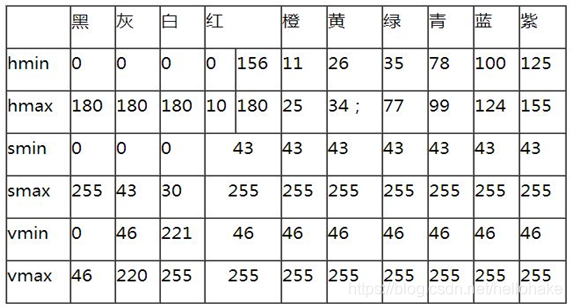

In [1354]:
class findCuttingLine():
    def __init__(self, img):
        self.contours, self.hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.mask=np.zeros((img.shape[0],img.shape[1]))
        self.direction=None
        self.cutting_line_contour=None
        self.profile={}
        self.filter_size()
    
    def filter_size(self):
        if self.hierarchy is not None :
            max_cont=0
            for index in range(len(self.hierarchy[0])):
                cont=self.contours[index]
                x, y, w, h = cv2.boundingRect(cont)
                a = cv2.contourArea(cont)
                if a>13000 and w>40 and h>40 and (h>400 or w>400) and (a>max_cont):
                    max_cont=a
                    self.cutting_line_contour=cont

            if self.cutting_line_contour is not None :
                x, y0, w0, h0 = cv2.boundingRect(self.cutting_line_contour)
                self.direction='cross' if (w0/h0 > 0.7)&(w0/h0 < 1.5) else 'hor' if w0/h0 > 3 else 'ver'
        else:
            print('條件符合的contours數量 = 0')
    
    def find_cutting_line_profile(self,thres,roi_ratio):
        if self.cutting_line_contour is not None :
            #step1 將contour填滿
            filled_contour=self.fill_contour(self.cutting_line_contour,self.mask)
            #step2 針對切割道方向不同，萃取profile
            if self.direction=='hor':
                self.profile['hor']=self.profile_handler(filled_contour,'hor',thres,roi_ratio)
            elif self.direction=='ver':
                self.profile['ver']=self.profile_handler(filled_contour,'ver',thres,roi_ratio)
            elif self.direction=='cross':
                self.profile['hor']=self.profile_handler(filled_contour,'hor',thres,roi_ratio)
                self.profile['ver']=self.profile_handler(filled_contour,'ver',thres,roi_ratio)
            else:
                print('self.direction=None')
                
        else:
            return None,None
        return self.profile, filled_contour
    
    def profile_handler(self,array,direction,thres,roi_ratio):
        n=0 if direction=='ver' else 1
        
        #step1 將填滿的contour座標，分別取x,y，並找出堆疊後最大值座標list
        axis_filled=np.array(array)[:,n]
        unique, counts = np.unique(axis_filled, return_counts=True)
        frequent_list=self.find_most_frequent(unique, counts)
        
        #step2 針對十字切割道過濾雜訊
        if self.direction=='cross':
            denoise_list=self.denoise(unique,counts,thres)
            denoised = [ x for x in axis_filled if x not in denoise_list]
        else :
            denoised=axis_filled
            
        d=int(abs((max(frequent_list)-min(frequent_list))*roi_ratio))
        roi_min=statistics.mean(frequent_list)-d if (statistics.mean(frequent_list)-d)>0 else 0
        roi_max=statistics.mean(frequent_list)+d
        return [roi_min, min(denoised), min(frequent_list), statistics.mean(frequent_list), max(frequent_list), max(denoised), roi_max]
    
    def fill_contour(self,contour,mask):
        filled_mask=cv2.drawContours(mask, [contour], -1, 1, -1)
        filled_contour=[]
        for x in range(filled_mask.shape[1]):
            for y in range(filled_mask.shape[0]):
                if filled_mask[y,x]==1:
                    filled_contour.append([x,y])
        return filled_contour
    
    def denoise(self,unique,counts,f):
        normalized_counts=[counts[i]/max(counts) for i in range(len(counts))]
        denoise_list=[unique[i] for i in range(len(normalized_counts)) if normalized_counts[i]<f]
        return denoise_list
        
    def find_most_frequent(self,unique,counts):
        frequent=[unique[i] for i in range(len(counts)) if counts[i]==max(counts)]
        return frequent
        
    def find_cutting_line_contour(self):
        return self.cutting_line_contour if self.cutting_line_contour is not None else None

In [1359]:
class imageProcessing():
    def __init__(self, img):
        self.hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        self.rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    def edge_computing(self,hsv_region):
        black_region = cv2.inRange(self.hsv, (0, 0, 0), hsv_region)
        image_MORPH = cv2.morphologyEx(black_region, cv2.MORPH_CLOSE, np.ones((6,6),np.uint8))
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        image_dilated = cv2.dilate(image_MORPH, kernel, iterations=2)
        return image_dilated
    
    def line_detection(self,filled_contour,profile,draw=False):
        #step1 hsv > s > convertScaleAbs > GaussianBlur > canny
        h, s, v = cv2.split(self.hsv)
        scaled = cv2.convertScaleAbs(s, alpha=2, beta=-5)
        blur = cv2.GaussianBlur(scaled,(3,3),0)
        sigma=0.33
        v = np.median(blur)
        lower = int(max(0,(1.0-sigma)*v))
        upper = int(min(255,(1.0+sigma)*v))
        dst = cv2.Canny(blur,lower,upper)
        
        #step2 filtered by filled_contour
        for cont in filled_contour:
            dst[cont[1]][cont[0]]=0
        
        #step3 filtered by roi range
        y1=profile['hor'][0] if 'hor' in profile.keys() else 10000
        y2=profile['hor'][6] if 'hor' in profile.keys() else 0
        x1=profile['ver'][0] if 'ver' in profile.keys() else 10000
        x2=profile['ver'][6] if 'ver' in profile.keys() else 0
        dst[0:y1,0:x1],dst[0:y1,x2:10000],dst[y2:10000,0:x1],dst[y2:10000,x2:10000]=0,0,0,0
        y_axis,x_axis=np.where(dst>1)
        
        #step4 draw plot
        if draw==True:
            plt.figure(figsize=(50, 200))
            plotimage(scaled,f"scaled",1,4,1)
            plotimage(blur,f"blur",1,4,2)
            plotimage(dst,f"dst",1,4,3)

        # step5 filter lines
        filtered={}
        for key in profile.keys():
            spec=profile[key]
            upper_range=list(range(spec[0],spec[3]))
            lower_range=list(range(spec[3],spec[6]))
            data=x_axis if key=='ver'else y_axis
            unique, counts = np.unique(data, return_counts=True)
            upper_max=0
            lower_max=0
            temp={}
            for i in range(len(unique)):
                axis=unique[i]
                cnt=counts[i]
                if axis in upper_range:
                    if cnt>upper_max:
                        upper_max=cnt
                        temp['upper']=axis
                        filtered[key]=temp
                if axis in lower_range:
                    if cnt>=lower_max:
                        lower_max=cnt
                        temp['lower']=axis
                        filtered[key]=temp
        return filtered

In [1360]:
def checkProfileSpec(dicts,f):
    result={}
    judge={}
    for key,values in dicts.items():
        if len(values)==7:
            try:
                d1=values[2]-values[1]
                d2=values[5]-values[4]
                dmin=round((values[4]-values[2])*f)
                result[key]=[d1,d2,dmin]
                judge[key]=1 if (dmin<=d1)|(dmin<=d2) else 0
            except Exception as e:
                print(e)
                print(values)
        else :
            print(f'資料數錯誤={len(values)}(=7)')
            
    final=1 if sum(judge.values())>=1 else 0
    return result,judge,final

def checkLinesSpec(lines,dicts):
    result={'hor':{'upper':0,'lower':0},'ver':{'upper':0,'lower':0}}
    judge={'hor':0,'ver':0}
    for key,values in dicts.items():
        if len(values)==7:
            try:
                upper_value=values[1]
                upper_spec=lines[key]["upper"]
                if (upper_value<upper_spec):
                    result[key]['upper']=1
                    judge[key]=1
            except Exception as e:
                print('[err]checkProfileSpec:',e)
            
            try:
                lower_value=values[5]
                lower_spec=lines[key]["lower"]
                if (lower_value>lower_spec):
                    result[key]['lower']=1
                    judge[key]=1
            except Exception as e:
                print('[err]checkProfileSpec:',e)
        else :
            print(f'資料數錯誤={len(values)}(=7)')
    final=1 if sum(judge.values())>=1 else 0
    return result,judge,final

# TEST

In [1361]:
def testing(filename_list,paths,classes,thres,roi,f,draw,save):
    prediction=[]
    done=0
    ts = time.time()
    for i in range(len(paths)):
        gt=classes[i]
        path=paths[i]
        name=filename_list[i]
        
        # step1 圖片前處理
        img = cv2.imread(path)
        prep=imageProcessing(img)
        binary_img=prep.edge_computing((180, 255, 30))
        
        # step3 切割道? 沒有:None,有:擷取切割道特徵
        cutting_line=findCuttingLine(binary_img)
        contour=cutting_line.find_cutting_line_contour()
        if contour is not None:
            profile,filled_contour=cutting_line.find_cutting_line_profile(thres,roi)
            filtered_lines=prep.line_detection(filled_contour,profile,draw)
            result,judge,final=checkLinesSpec(filtered_lines,profile)
            result_prof,judge_prof,final_prof=checkProfileSpec(profile,f)
            pred=1 if (final+final_prof)>=1 else 0
            prediction.append([gt, final, final_prof, pred])
        else :
            prediction.append([gt,'NA','NA','NA'])
        
        done+=1
        if done%100==0:
            tp = time.time()
            print('done=',done)
            print('共耗時:',round((tp - ts),2),'秒')
            print('FPS:',done/round((tp - ts),2),'張/秒')
        
        if draw==True:
            img_rgb=prep.rgb
            # draw spec
            for key,values in filtered_lines.items():
                if key=='ver':
                    try:
                        pt1=(values['upper'],1000)
                        pt2=(values['upper'],-1000)
                        cv2.line(img_rgb, pt1, pt2, (0, 0, 255), 2)
                    except:
                        print('[err]draw spec: ver upper')
                    try:
                        pt1=(values['lower'],1000)
                        pt2=(values['lower'],-1000)
                        cv2.line(img_rgb, pt1, pt2, (0, 0, 255), 2)
                    except:
                        print('[err]draw spec: ver lower')
                if  key=='hor':
                    try:
                        pt1=(1000,values['upper'])
                        pt2=(-1000,values['upper'])
                        cv2.line(img_rgb, pt1, pt2, (0, 0, 255), 2)
                    except:
                        print('[err]draw spec: hor upper')
                    try:
                        pt1=(1000,values['lower'])
                        pt2=(-1000,values['lower'])
                        cv2.line(img_rgb, pt1, pt2, (0, 0, 255), 2)
                    except:
                        print('[err]draw spec: hor lower')

            # draw profile
            for key,values in profile.items():
                for value in values:
                    if key=='ver':
                        pt1=(value,1000)
                        pt2=(value,-1000)
                        cv2.line(img_rgb, pt1, pt2, (50,205,50), 1)
                    if  key=='hor':
                        pt1=(1000,value)
                        pt2=(-1000,value)
                        cv2.line(img_rgb, pt1, pt2, (50,205,50), 1)

            plt.figure(figsize=(50, 200))
            classes_list={0:'OK',1:'NG'}
            plotimage(img_rgb,f"GT={gt};pred={classes_list[pred]};line={classes_list[final]};prof={classes_list[final_prof]}---{result_prof}",1,4,1)
        
        
        if save==True:
            # save image
            folder='N3' if (pred==0)&(gt=="NG") else 'N6' if (pred==1)&(gt=="OK") else 'N2' if (pred==0)&(gt=="OK") else 'N5' if (pred==1)&(gt=="NG") else 'NA'
            if not os.path.isdir(f'pred_imgs/0927/{folder}/'):
                os.makedirs(f'pred_imgs/0927/{folder}/')
            cv2.imwrite(f'pred_imgs/0927/{folder}/{name}', cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
            
    tn = time.time()
    print('--------------------------------------')
    print('已全部完成=',done)
    print('共耗時:',round((tn - ts), 2), '秒')
    print('FPS:',done/round((tn - ts), 2), '張/秒')
    print('--------------------------------------')
    return prediction

thres= 0.2 ; f= 0.3 ; roi= 1.2


KeyboardInterrupt: 

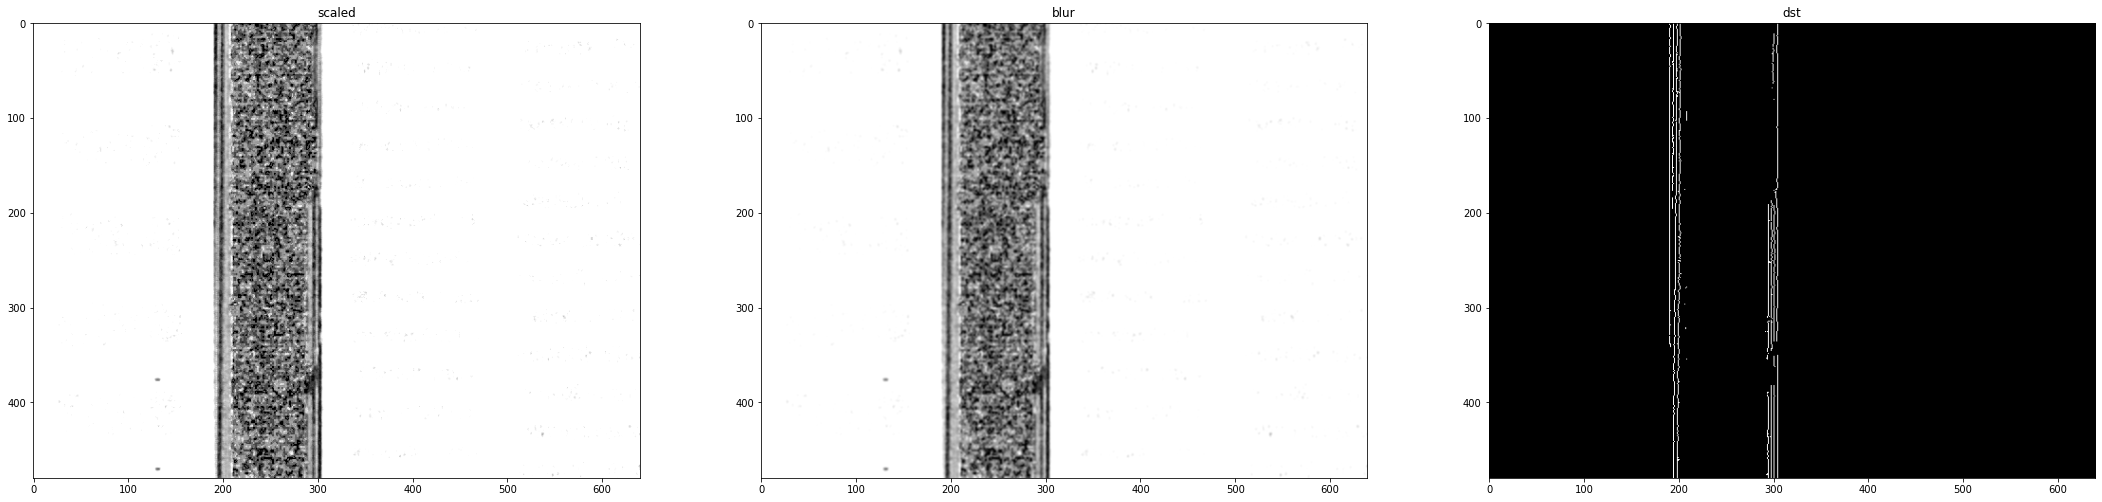

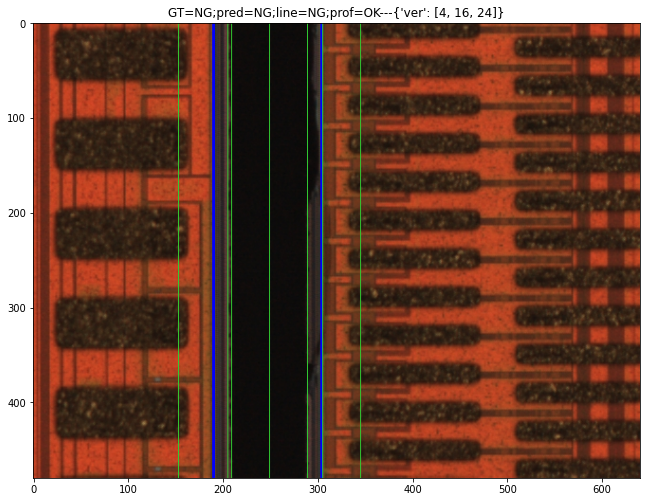

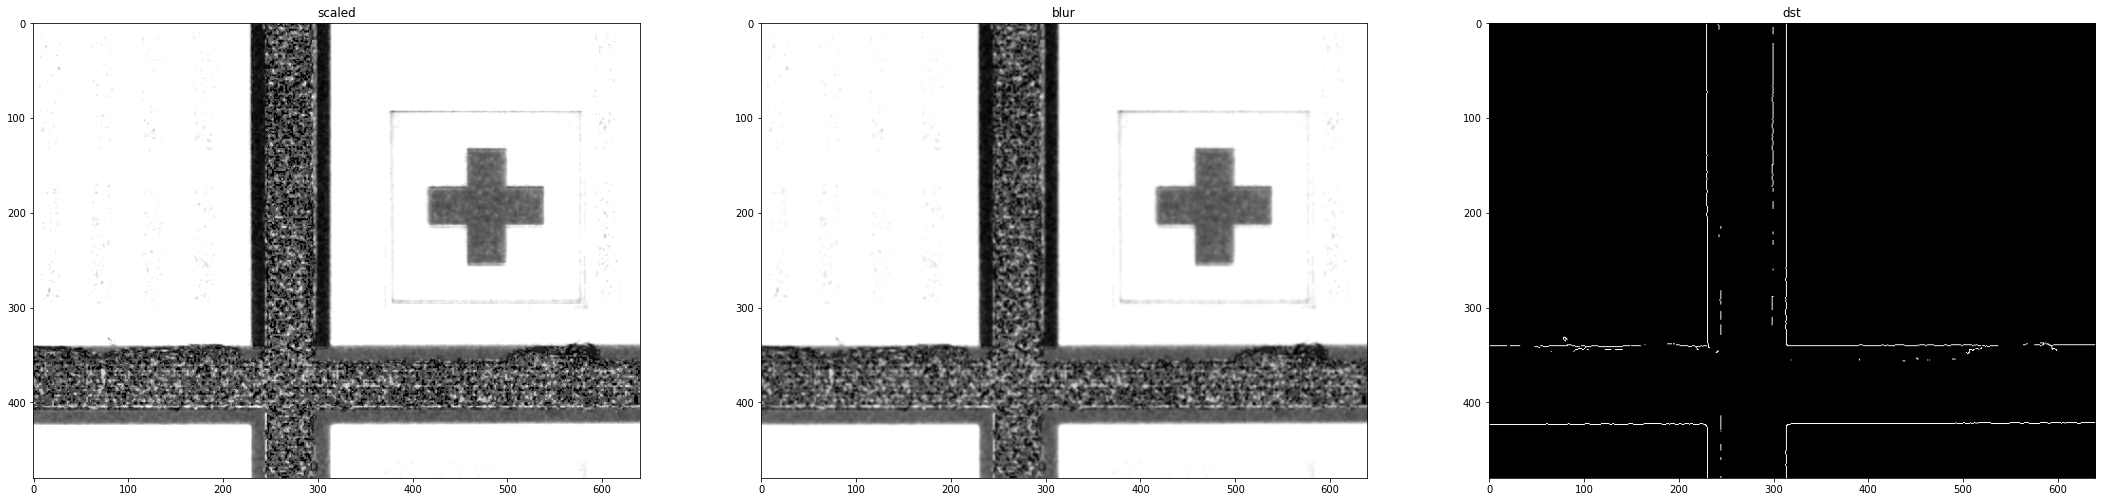

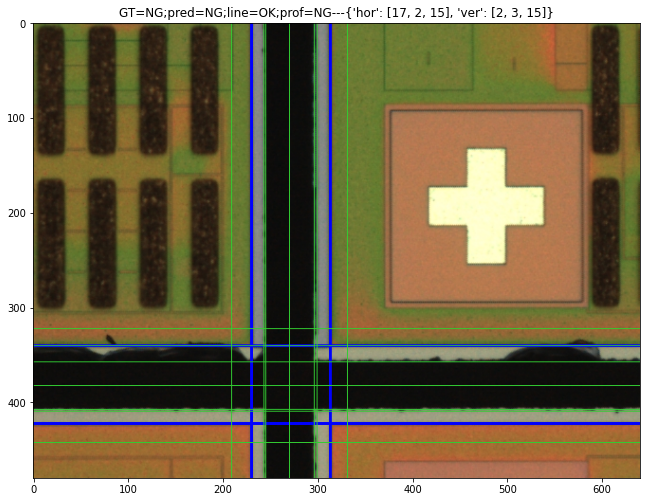

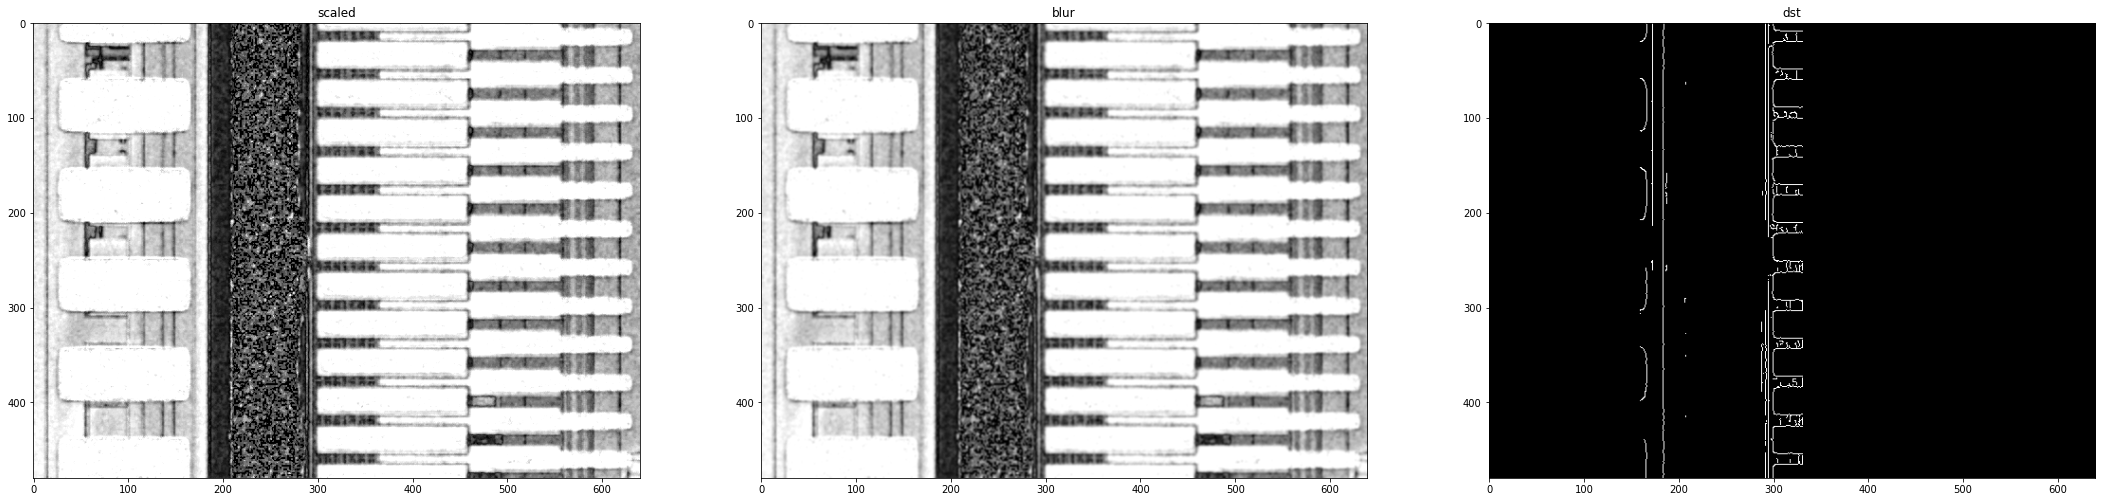

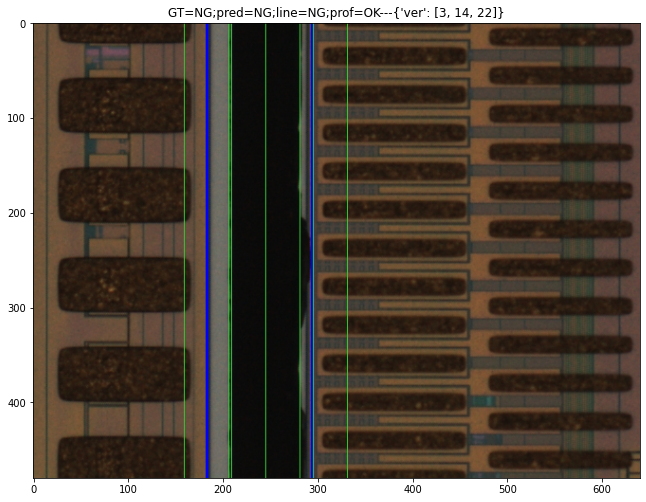

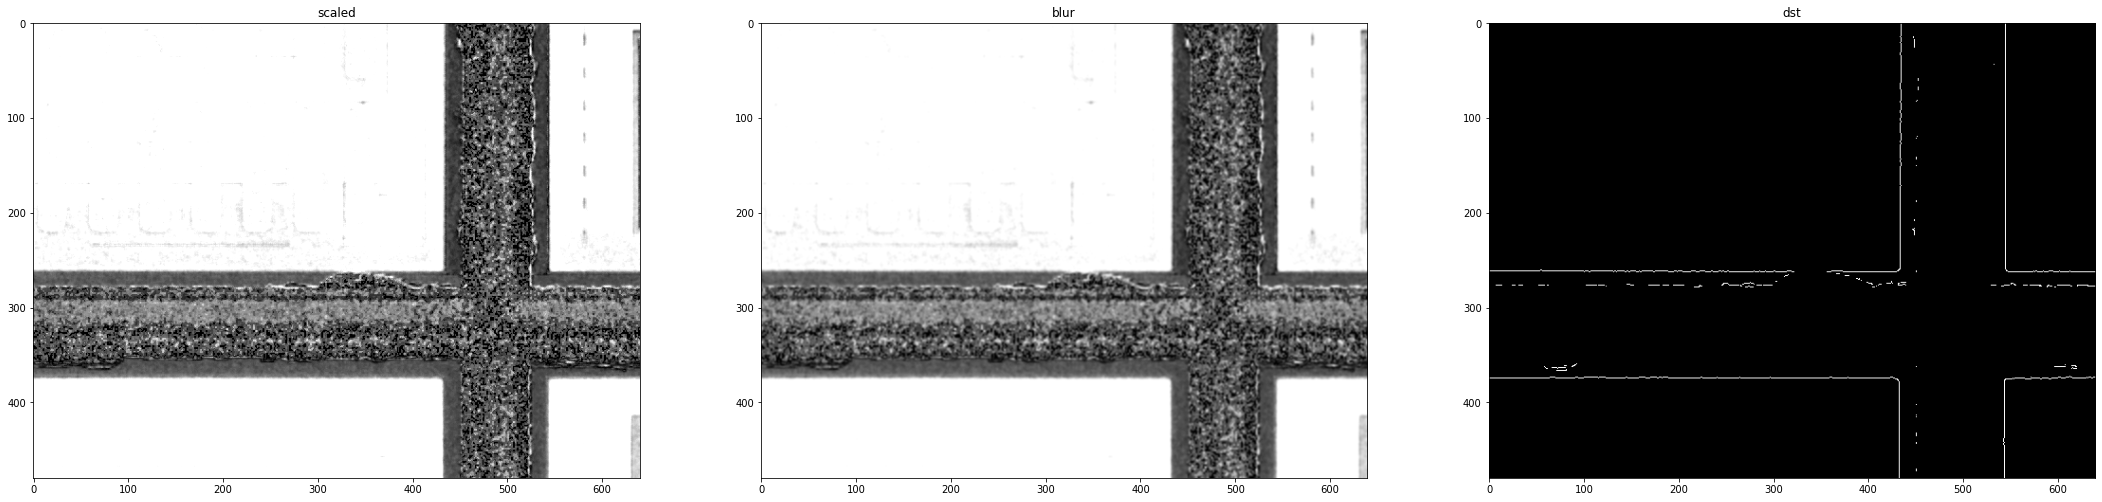

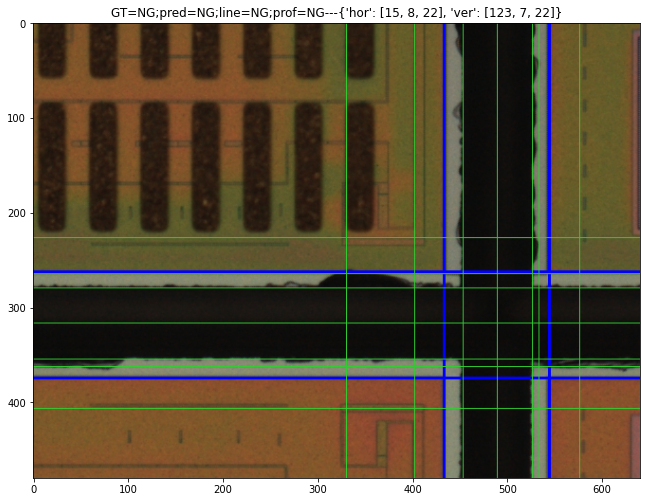

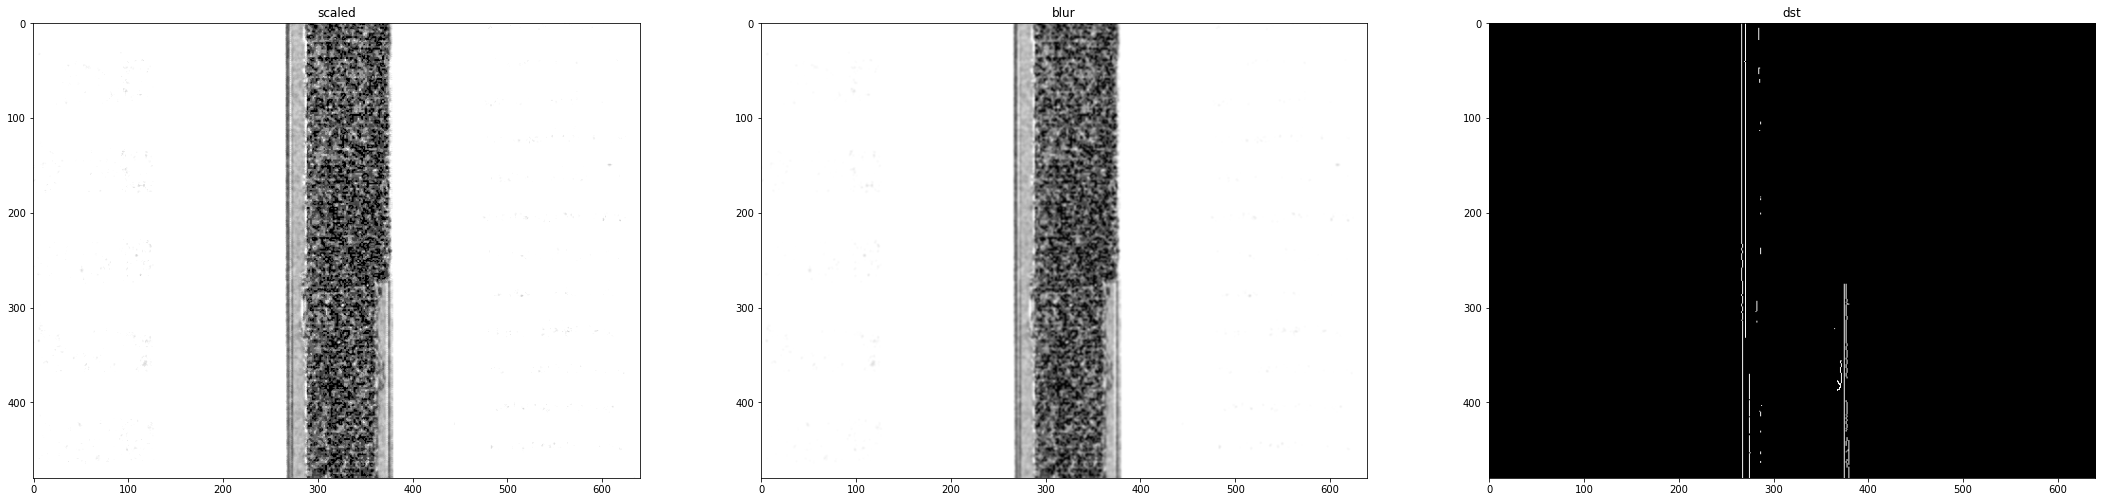

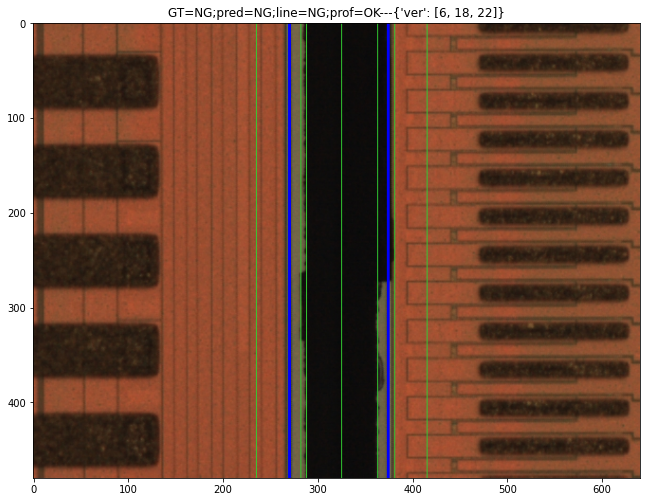

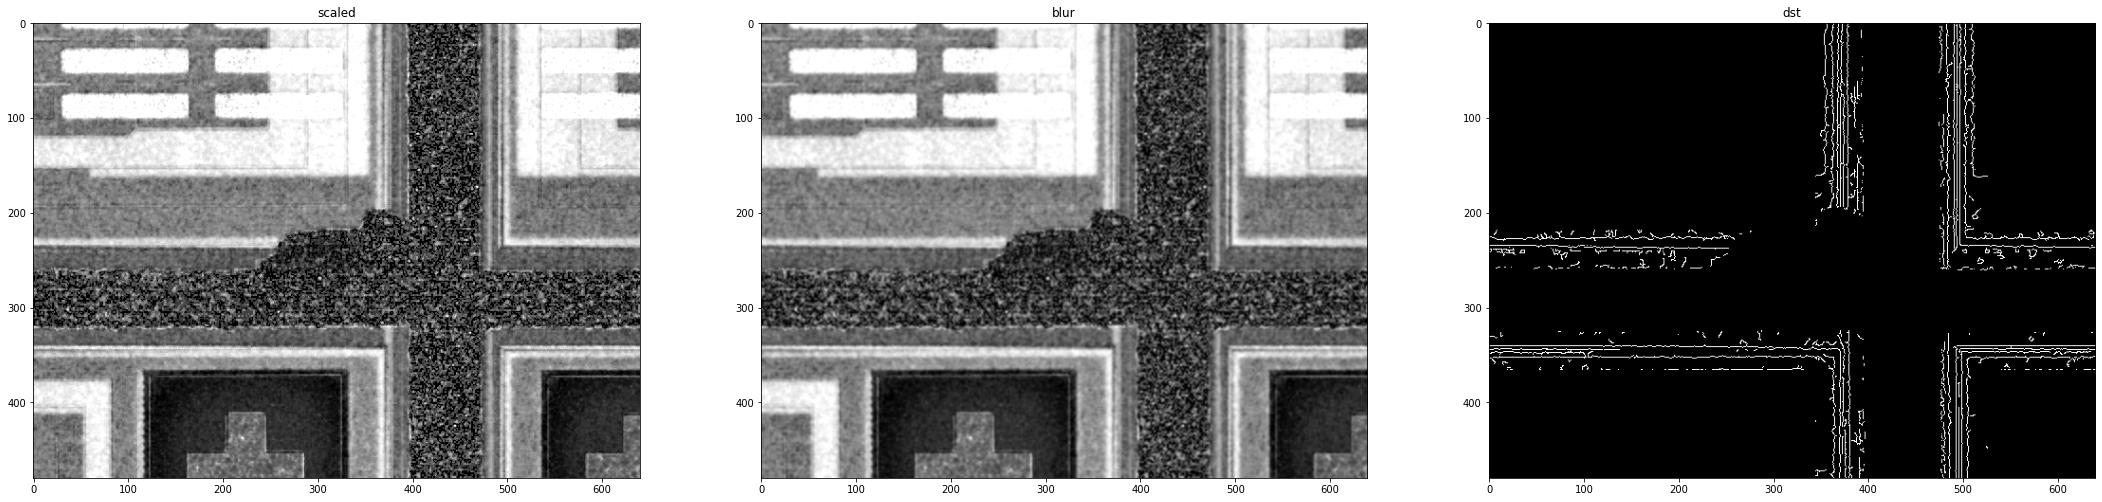

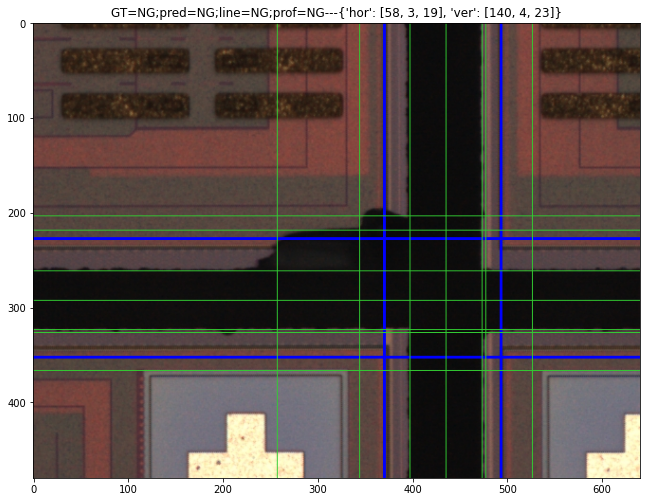

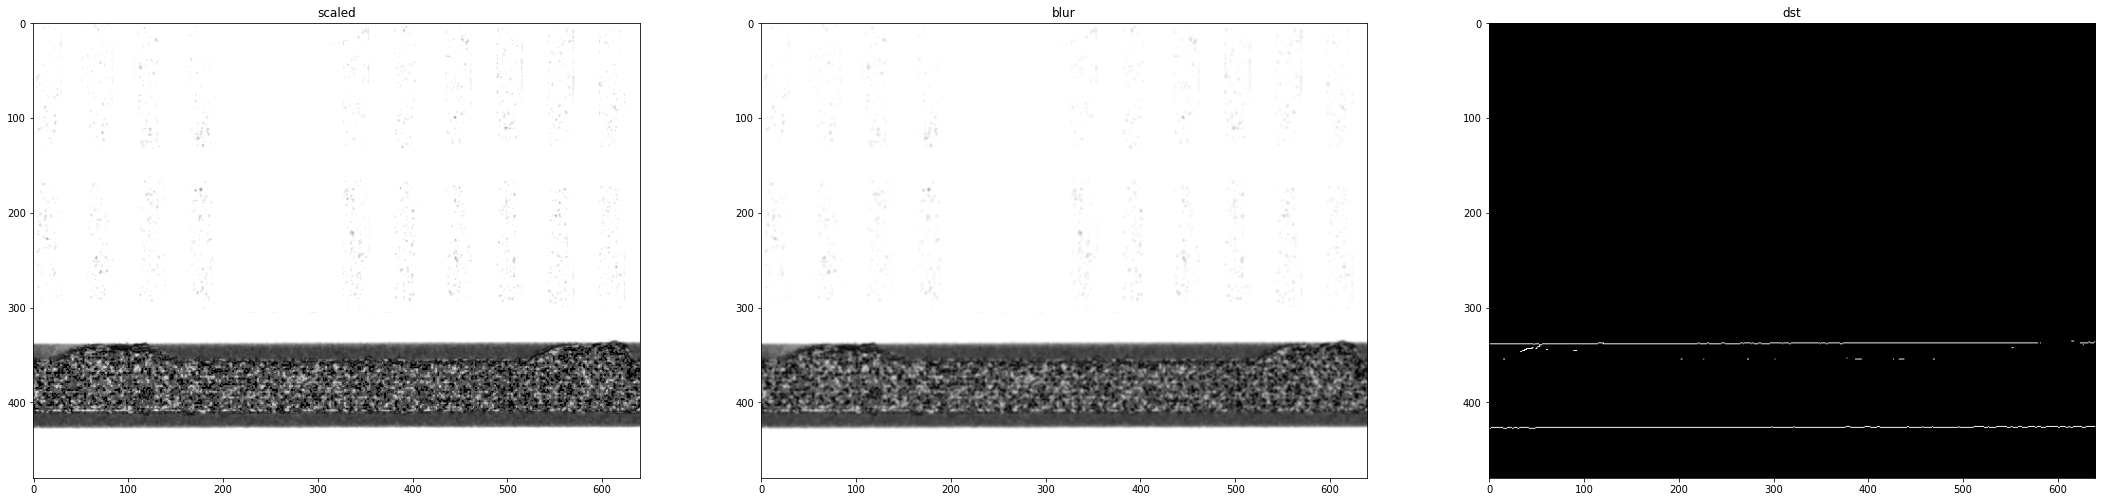

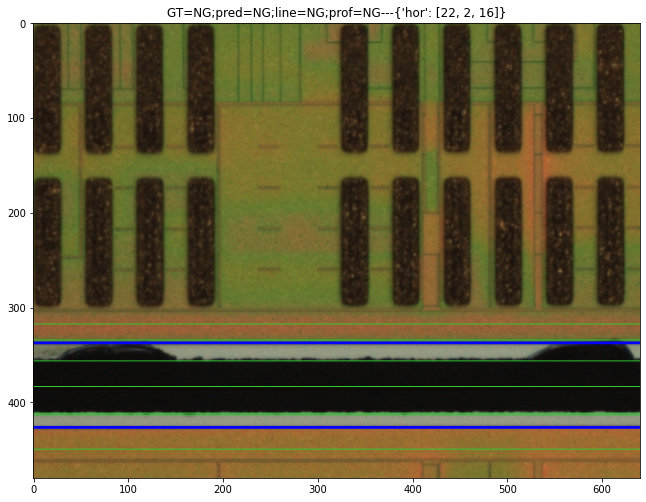

In [1362]:
path_list=test['fullPath'].values
class_list=test['class'].values
filename_list=test['fileName'].values
thres=0.2
roi=1.2
f=0.3

print('thres=',thres,'; f=',f,'; roi=',roi)
prediction=testing(filename_list,path_list,class_list,thres,roi,f,True,False)

In [1350]:
test_result=test.copy()
test_result[f'prediction_lines']=np.array(prediction)[:,1]
test_result[f'prediction_profile']=np.array(prediction)[:,2]
test_result[f'prediction']=np.array(prediction)[:,3]
test_result.to_excel('result-0921.xlsx')
test_crosstab=pd.crosstab(test_result['prediction'], test_result['class'])
test_crosstab

class       NG   OK
prediction         
0           11  732
1           59  267
NA           0    1